In [8]:
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

In [4]:
N = 5
K = 30

alpha = 2
P0 = sp.stats.norm
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)

In [6]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = P0.rvs(size=(N, K))
x_plot = np.linspace(-3, 3, 200)
dpm_pdf_components = f(x_plot[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

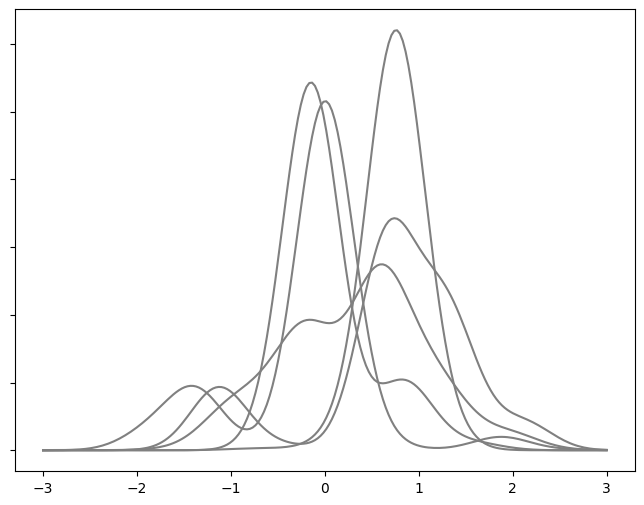

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c="gray")

ax.set_yticklabels([]);

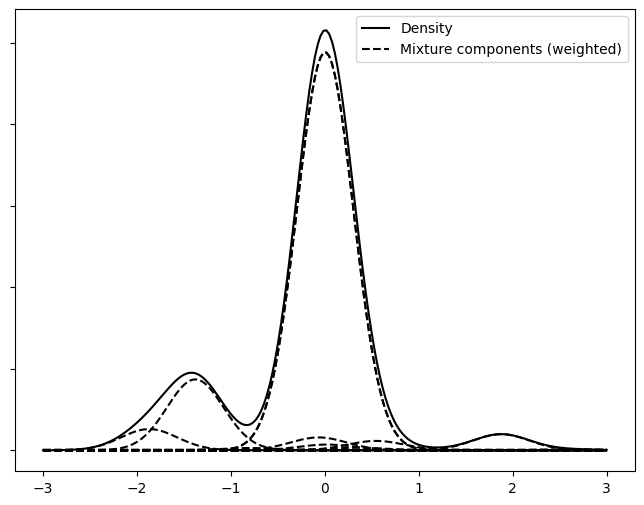

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ix = 1

ax.plot(x_plot, dpm_pdfs[ix], c="k", label="Density")
ax.plot(
    x_plot,
    (w[..., np.newaxis] * dpm_pdf_components)[ix, 0],
    "--",
    c="k",
    label="Mixture components (weighted)",
)
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T, "--", c="k")

ax.set_yticklabels([])
ax.legend(loc=1);

In [12]:
old_faithful_df = pd.read_csv(pm.get_data("old_faithful.csv"))
old_faithful_df["std_waiting"] = (
    old_faithful_df.waiting - old_faithful_df.waiting.mean()
) / old_faithful_df.waiting.std()



In [13]:
old_faithful_df.head()

,eruptions,waiting,std_waiting
0,3.600,79,0.596025
1,1.800,54,-1.242890
2,3.333,74,0.228242
3,2.283,62,-0.654437
4,4.533,85,1.037364


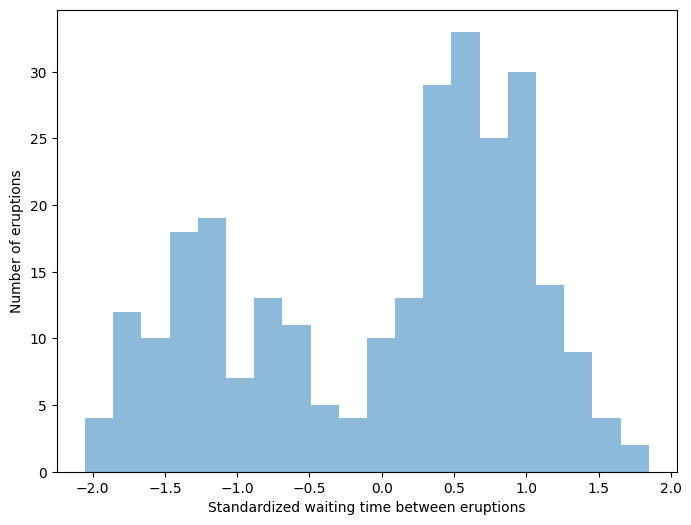

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, *_ = sns.color_palette()
n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, color=blue, lw=0, alpha=0.5)

ax.set_xlabel("Standardized waiting time between eruptions")
ax.set_ylabel("Number of eruptions");

In [16]:
N = old_faithful_df.shape[0]

K = 30



In [17]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining



In [18]:
with pm.Model() as model:
    alpha = pm.Gamma("alpha", 1.0, 1.0)
    beta = pm.Beta("beta", 1.0, alpha, shape=K)
    w = pm.Deterministic("w", stick_breaking(beta))

    tau = pm.Gamma("tau", 1.0, 1.0, shape=K)
    lambda_ = pm.Gamma("lambda_", 10.0, 1.0, shape=K)
    mu = pm.Normal("mu", 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture(
        "obs", w, mu, tau=lambda_ * tau, observed=old_faithful_df.std_waiting.values
    )

C:\Users\bernstwgj\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


In [20]:
with model:
    trace = pm.sample(1000, tune=2500, chains=2, init="advi", target_accept=0.9, random_seed=2023)

C:\Users\bernstwgj\AppData\Roaming\Python\Python310\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Interrupted at 114 [0%]: Average Loss = 726
C:\Users\bernstwgj\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bernstwgj\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\bernstwgj\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, lambda_, tau, beta, alpha]


ValueError: Not enough samples to build a trace.